# Q1. Baseline CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13), (0.3))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

torch.manual_seed(42)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class CNN(nn.Module):
    def __init__(self,kernel_size=3, activition_function="ReLU", is_deep=False):
        super(CNN, self).__init__()
        
        self.is_deep = is_deep
        
        if(activition_function == "ReLU"):
            self.activition_function = nn.ReLU
        elif(activition_function == "LeakyReLU"):
            self.activition_function = nn.LeakyReLU
        elif(activition_function == "Tanh"):
            self.activition_function = nn.Tanh
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size)
        self.relu1 = self.activition_function()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size)
        self.relu2 = self.activition_function() 
        self.pool2 = nn.MaxPool2d(2, 2)

        self.deep_conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size)
        self.deep_relu3 = self.activition_function() 
        self.deep_pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (((28 - kernel_size + 1) // 2 - kernel_size + 1) // 2) * (((28 - kernel_size + 1) // 2 - kernel_size + 1) // 2), 128)
        self.deep_fc1 = nn.Linear(128, 128)
        self.relu3 = self.activition_function() 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        if(self.is_deep):
            x = self.deep_pool3(self.deep_relu3(self.deep_conv3(x)))
            x = self.flatten(x)
            x = self.dropout(self.relu3(self.deep_fc1(x)))
        else:
            x = self.flatten(x)
            x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
def evaluate_model(model, criterion, optimizer, epochs = 10):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            probababilities = torch.nn.functional.softmax(outputs, dim=1)
            x, predicted = torch.max(probababilities.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                probababilities = torch.nn.functional.softmax(outputs, dim=1)
                x, predicted = torch.max(probababilities.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_acc = 100 * test_correct / test_total
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(1, epochs)
    plt.ylim(bottom=0)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xlim(1, epochs)
    plt.ylim(top=100)
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10, Loss: 0.2064, Train Acc: 93.67%, Test Acc: 98.53%
Epoch 2/10, Loss: 0.0786, Train Acc: 97.66%, Test Acc: 98.93%
Epoch 3/10, Loss: 0.0608, Train Acc: 98.19%, Test Acc: 98.89%
Epoch 4/10, Loss: 0.0480, Train Acc: 98.53%, Test Acc: 99.13%
Epoch 5/10, Loss: 0.0408, Train Acc: 98.81%, Test Acc: 99.18%
Epoch 6/10, Loss: 0.0326, Train Acc: 98.98%, Test Acc: 99.25%
Epoch 7/10, Loss: 0.0305, Train Acc: 99.05%, Test Acc: 99.15%
Epoch 8/10, Loss: 0.0259, Train Acc: 99.19%, Test Acc: 99.30%
Epoch 9/10, Loss: 0.0239, Train Acc: 99.27%, Test Acc: 99.21%
Epoch 10/10, Loss: 0.0223, Train Acc: 99.26%, Test Acc: 99.24%


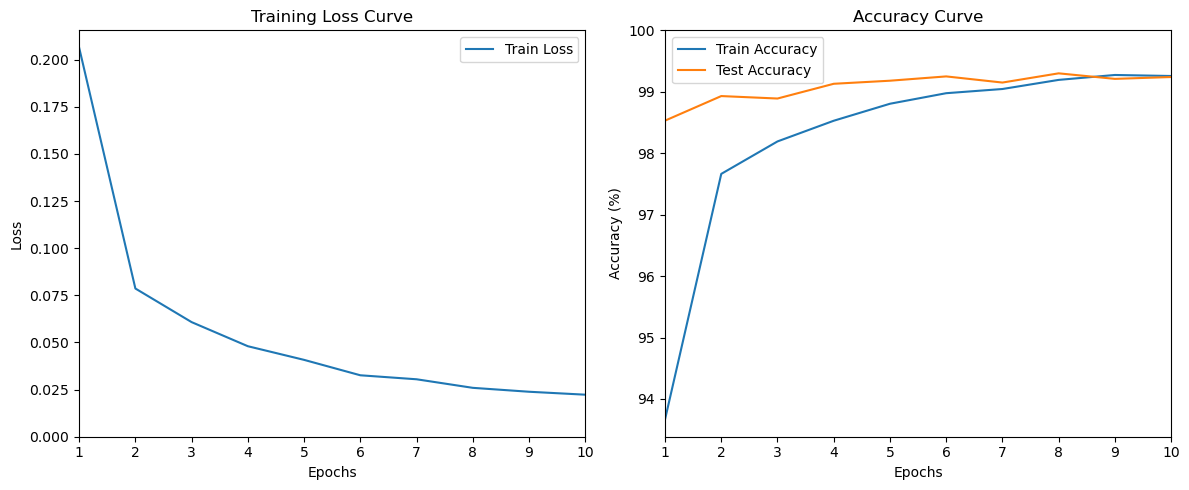

In [3]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, criterion, optimizer)

# Q2. Architectural variants

## 5x5 kernel size

Epoch 1/10, Loss: 0.1964, Train Acc: 93.98%, Test Acc: 98.65%
Epoch 2/10, Loss: 0.0681, Train Acc: 98.05%, Test Acc: 99.14%
Epoch 3/10, Loss: 0.0508, Train Acc: 98.45%, Test Acc: 99.10%
Epoch 4/10, Loss: 0.0414, Train Acc: 98.80%, Test Acc: 99.13%
Epoch 5/10, Loss: 0.0356, Train Acc: 98.89%, Test Acc: 99.14%
Epoch 6/10, Loss: 0.0324, Train Acc: 99.01%, Test Acc: 99.23%
Epoch 7/10, Loss: 0.0251, Train Acc: 99.23%, Test Acc: 99.12%
Epoch 8/10, Loss: 0.0235, Train Acc: 99.25%, Test Acc: 99.38%
Epoch 9/10, Loss: 0.0211, Train Acc: 99.32%, Test Acc: 99.17%
Epoch 10/10, Loss: 0.0182, Train Acc: 99.42%, Test Acc: 99.29%


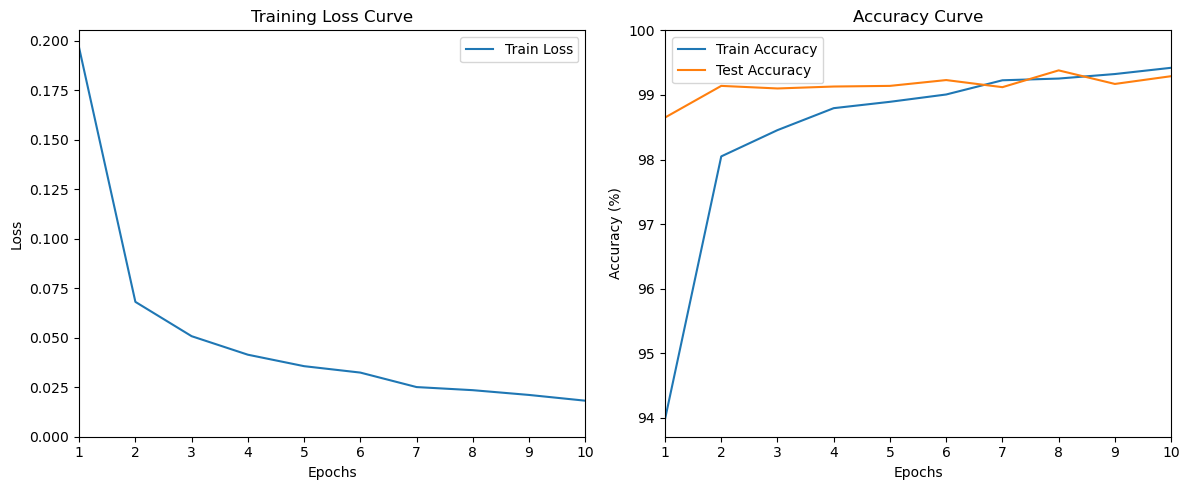

In [4]:
model = CNN(kernel_size=5)
criterion = nn.CrossEntropyLoss()                           
optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, criterion, optimizer)

## LeakyReLU

Epoch 1/10, Loss: 0.1884, Train Acc: 94.23%, Test Acc: 98.62%
Epoch 2/10, Loss: 0.0649, Train Acc: 98.04%, Test Acc: 98.72%
Epoch 3/10, Loss: 0.0500, Train Acc: 98.48%, Test Acc: 99.15%
Epoch 4/10, Loss: 0.0406, Train Acc: 98.77%, Test Acc: 99.08%
Epoch 5/10, Loss: 0.0334, Train Acc: 99.00%, Test Acc: 99.04%
Epoch 6/10, Loss: 0.0307, Train Acc: 99.03%, Test Acc: 99.01%
Epoch 7/10, Loss: 0.0269, Train Acc: 99.15%, Test Acc: 99.28%
Epoch 8/10, Loss: 0.0217, Train Acc: 99.31%, Test Acc: 99.28%
Epoch 9/10, Loss: 0.0196, Train Acc: 99.36%, Test Acc: 99.22%
Epoch 10/10, Loss: 0.0189, Train Acc: 99.37%, Test Acc: 99.34%


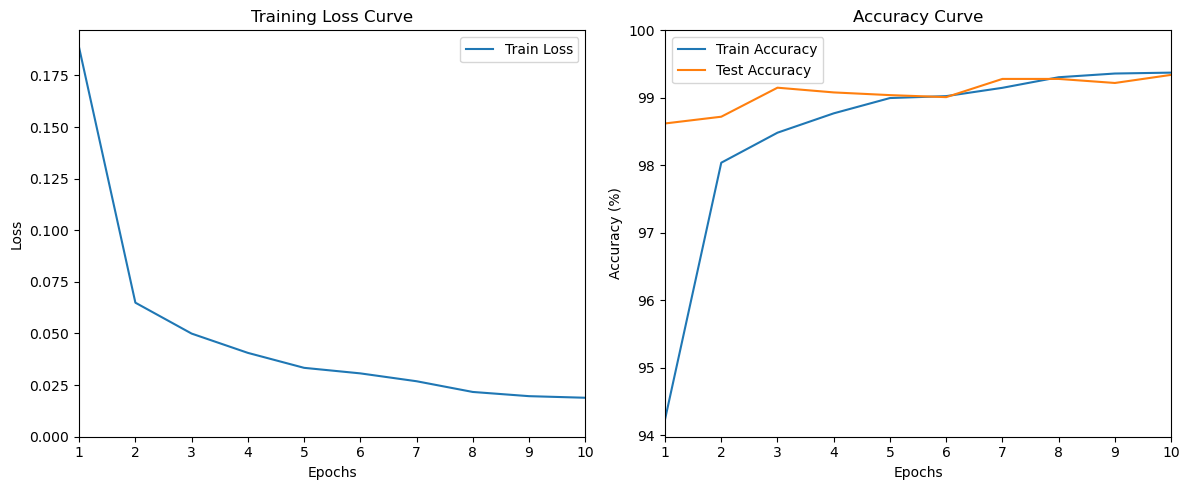

In [5]:
model = CNN(activition_function="LeakyReLU")
criterion = nn.CrossEntropyLoss()                           
optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, criterion, optimizer)

## Tanh 

Epoch 1/10, Loss: 0.1669, Train Acc: 95.22%, Test Acc: 98.38%
Epoch 2/10, Loss: 0.0664, Train Acc: 97.98%, Test Acc: 98.66%
Epoch 3/10, Loss: 0.0560, Train Acc: 98.32%, Test Acc: 98.80%
Epoch 4/10, Loss: 0.0501, Train Acc: 98.43%, Test Acc: 98.96%
Epoch 5/10, Loss: 0.0440, Train Acc: 98.61%, Test Acc: 98.88%
Epoch 6/10, Loss: 0.0430, Train Acc: 98.69%, Test Acc: 99.01%
Epoch 7/10, Loss: 0.0374, Train Acc: 98.81%, Test Acc: 98.94%
Epoch 8/10, Loss: 0.0358, Train Acc: 98.89%, Test Acc: 99.00%
Epoch 9/10, Loss: 0.0327, Train Acc: 98.97%, Test Acc: 99.12%
Epoch 10/10, Loss: 0.0330, Train Acc: 98.96%, Test Acc: 98.88%


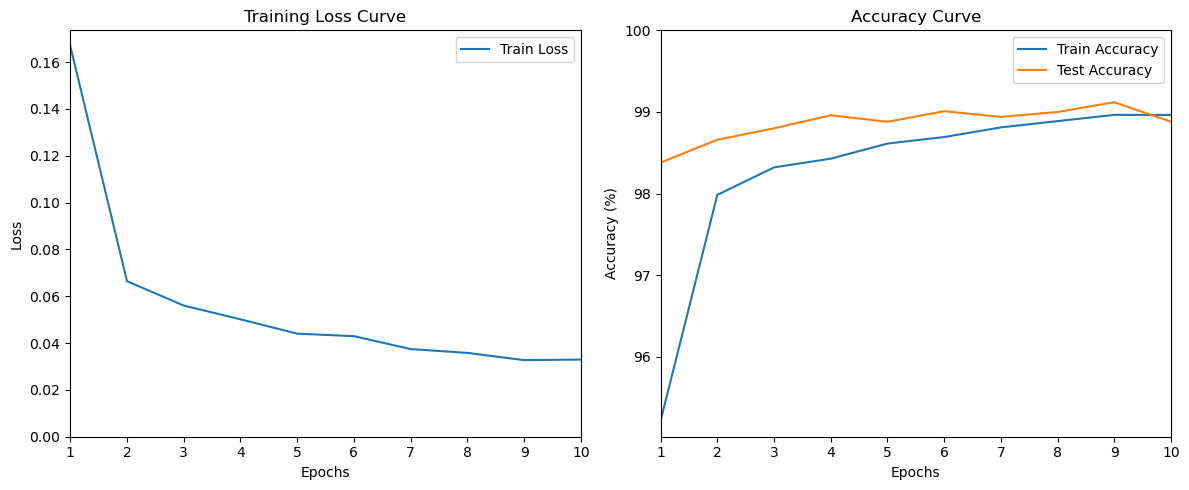

In [6]:
model = CNN(activition_function="Tanh")
criterion = nn.CrossEntropyLoss()                          
optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, criterion, optimizer)

## Deeper network (3 conv blocks)

Epoch 1/10, Loss: 0.2883, Train Acc: 90.96%, Test Acc: 97.82%
Epoch 2/10, Loss: 0.0892, Train Acc: 97.42%, Test Acc: 98.39%
Epoch 3/10, Loss: 0.0641, Train Acc: 98.10%, Test Acc: 98.63%
Epoch 4/10, Loss: 0.0513, Train Acc: 98.51%, Test Acc: 98.60%
Epoch 5/10, Loss: 0.0409, Train Acc: 98.83%, Test Acc: 98.14%
Epoch 6/10, Loss: 0.0364, Train Acc: 98.91%, Test Acc: 98.66%
Epoch 7/10, Loss: 0.0306, Train Acc: 99.06%, Test Acc: 98.79%
Epoch 8/10, Loss: 0.0255, Train Acc: 99.21%, Test Acc: 98.89%
Epoch 9/10, Loss: 0.0216, Train Acc: 99.40%, Test Acc: 98.67%
Epoch 10/10, Loss: 0.0214, Train Acc: 99.36%, Test Acc: 98.85%


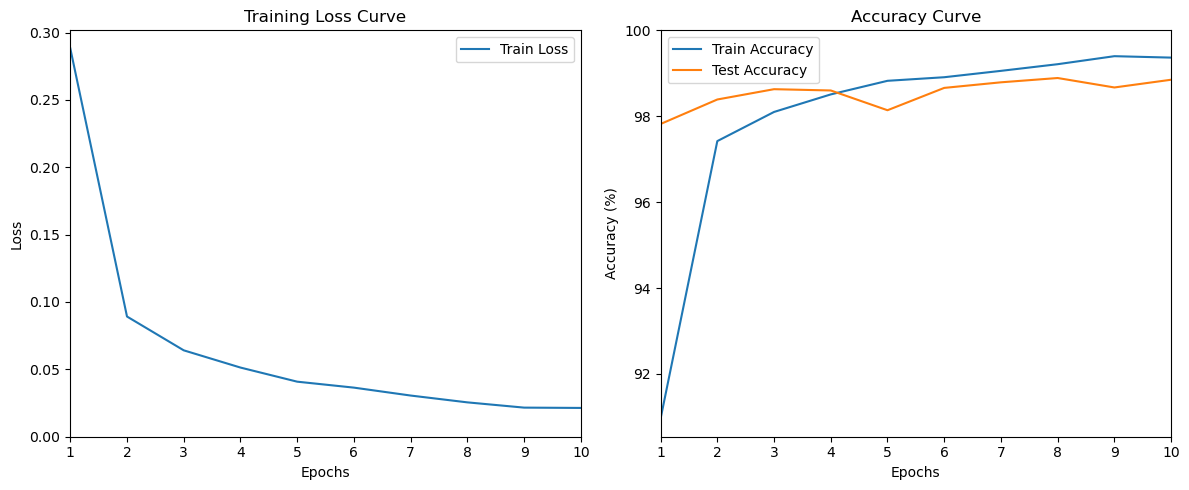

In [7]:
model = CNN(is_deep=True)
criterion = nn.CrossEntropyLoss()                           
optimizer = optim.Adam(model.parameters(), lr=0.001)
evaluate_model(model, criterion, optimizer)

# Q3. Varying parameters

In [8]:
def test_parameters(learning_rate=0.001, optimizer_type='Adam', batch_size=64, dropout=0.5, weight_init=None, epochs=10):
    torch.manual_seed(42)
    train_loader_local = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader_local = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

    model_local = CNN()
    model_local.dropout.p = dropout

    if weight_init is not None:
        for m in model_local.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                weight_init(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    if optimizer_type == 'Adam':
        optimizer_local = optim.Adam(model_local.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer_local = optim.SGD(model_local.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model_local.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader_local:
            optimizer_local.zero_grad()
            outputs = model_local(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_local.step()

            running_loss += loss.item()
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            a, predicted = torch.max(probabilities.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader_local)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model_local.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader_local:
                outputs = model_local(images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                a, predicted = torch.max(probabilities.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_acc = 100 * test_correct / test_total
        test_accuracies.append(test_acc)

    return {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'test_accuracy': test_accuracies
    }

## Optimizers

Adam optimizer:
Epoch 1/10, Loss: 0.2316, Train Acc: 92.95%, Test Acc: 98.31%
Epoch 2/10, Loss: 0.0837, Train Acc: 97.61%, Test Acc: 98.87%
Epoch 3/10, Loss: 0.0624, Train Acc: 98.15%, Test Acc: 99.10%
Epoch 4/10, Loss: 0.0525, Train Acc: 98.42%, Test Acc: 99.27%
Epoch 5/10, Loss: 0.0424, Train Acc: 98.73%, Test Acc: 99.12%
Epoch 6/10, Loss: 0.0368, Train Acc: 98.88%, Test Acc: 99.20%
Epoch 7/10, Loss: 0.0316, Train Acc: 99.03%, Test Acc: 99.21%
Epoch 8/10, Loss: 0.0300, Train Acc: 99.04%, Test Acc: 99.20%
Epoch 9/10, Loss: 0.0260, Train Acc: 99.18%, Test Acc: 99.27%
Epoch 10/10, Loss: 0.0235, Train Acc: 99.25%, Test Acc: 99.23%
SGD optimizer:
Epoch 1/10, Loss: 2.1651, Train Acc: 31.63%, Test Acc: 72.34%
Epoch 2/10, Loss: 1.3686, Train Acc: 63.21%, Test Acc: 82.51%
Epoch 3/10, Loss: 0.7444, Train Acc: 77.72%, Test Acc: 88.67%
Epoch 4/10, Loss: 0.5605, Train Acc: 83.32%, Test Acc: 90.44%
Epoch 5/10, Loss: 0.4716, Train Acc: 85.91%, Test Acc: 91.49%
Epoch 6/10, Loss: 0.4184, Train Acc: 8

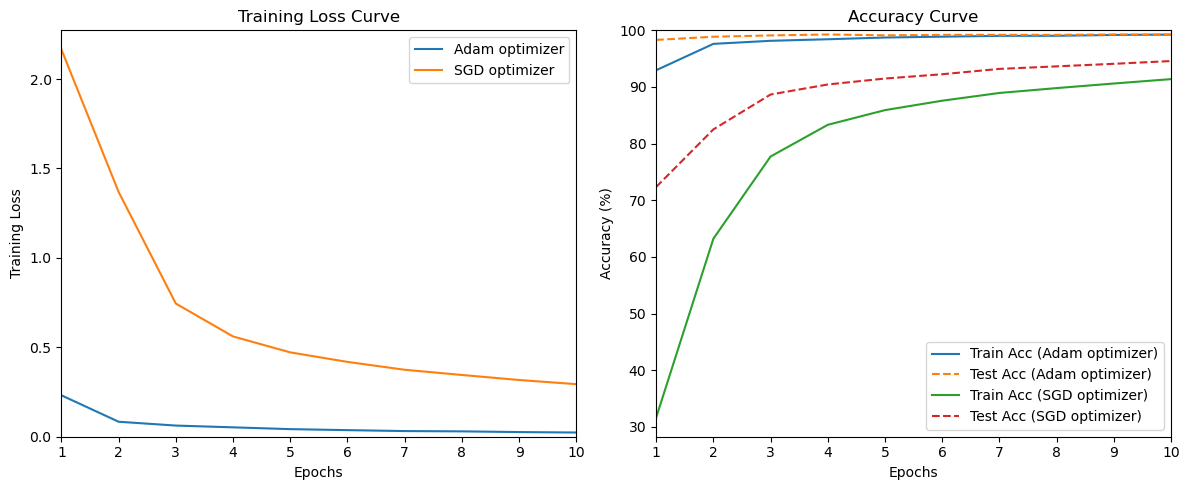

In [9]:
optimizer_types = ['Adam', 'SGD']
results = {}
epochs = 10

for ot in optimizer_types:
    stats = test_parameters(optimizer_type=ot, epochs=epochs)
    results[ot] = stats
  
    for epoch in range(epochs):
        if epoch == 0:
            print(f"{ot} optimizer:")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[ot]['train_loss'][epoch]:.4f}, Train Acc: {results[ot]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[ot]['test_accuracy'][epoch]:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[ot]['train_loss'][epoch]:.4f}, Train Acc: {results[ot]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[ot]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for ot in optimizer_types:
    plt.plot(range(1, len(results[ot]['train_loss']) + 1), results[ot]['train_loss'], label=f'{ot} optimizer')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for ot in optimizer_types:
    plt.plot(range(1, len(results[ot]['train_accuracy']) + 1), results[ot]['train_accuracy'], label=f'Train Acc ({ot} optimizer)')
    plt.plot(range(1, len(results[ot]['test_accuracy']) + 1), results[ot]['test_accuracy'], linestyle='--', label=f'Test Acc ({ot} optimizer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Batch sizes

Batch size=16:
Epoch 1/10, Loss: 0.1797, Train Acc: 94.65%, Test Acc: 98.47%
Epoch 2/10, Loss: 0.0753, Train Acc: 97.81%, Test Acc: 98.94%
Epoch 3/10, Loss: 0.0567, Train Acc: 98.33%, Test Acc: 99.03%
Epoch 4/10, Loss: 0.0458, Train Acc: 98.60%, Test Acc: 99.21%
Epoch 5/10, Loss: 0.0391, Train Acc: 98.88%, Test Acc: 99.10%
Epoch 6/10, Loss: 0.0334, Train Acc: 98.98%, Test Acc: 99.10%
Epoch 7/10, Loss: 0.0308, Train Acc: 99.05%, Test Acc: 99.11%
Epoch 8/10, Loss: 0.0272, Train Acc: 99.16%, Test Acc: 99.20%
Epoch 9/10, Loss: 0.0265, Train Acc: 99.25%, Test Acc: 99.26%
Epoch 10/10, Loss: 0.0239, Train Acc: 99.27%, Test Acc: 99.13%
Batch size=32:
Epoch 1/10, Loss: 0.1953, Train Acc: 94.07%, Test Acc: 98.57%
Epoch 2/10, Loss: 0.0783, Train Acc: 97.74%, Test Acc: 99.10%
Epoch 3/10, Loss: 0.0575, Train Acc: 98.27%, Test Acc: 99.11%
Epoch 4/10, Loss: 0.0474, Train Acc: 98.54%, Test Acc: 99.21%
Epoch 5/10, Loss: 0.0384, Train Acc: 98.87%, Test Acc: 99.15%
Epoch 6/10, Loss: 0.0355, Train Acc: 98

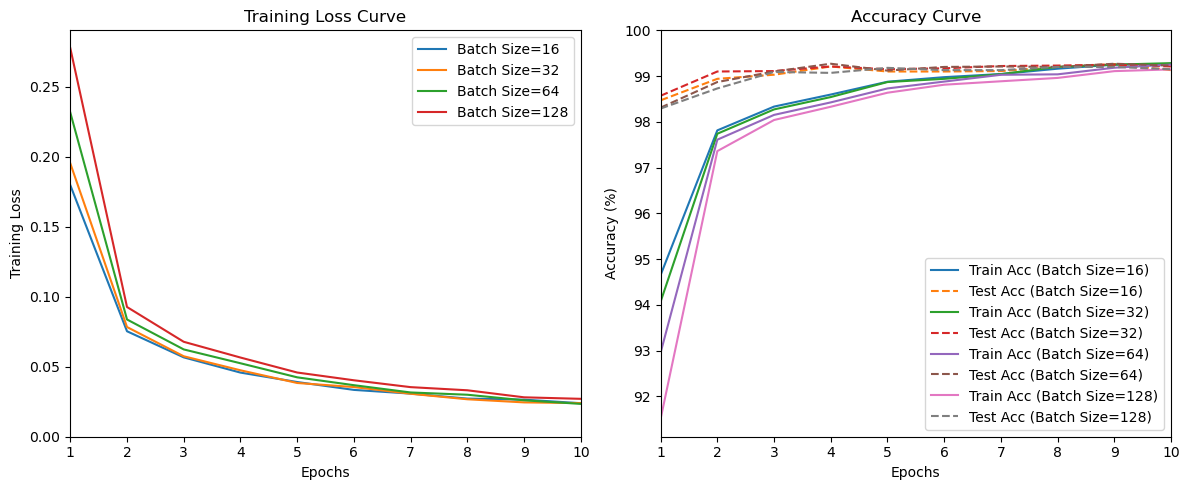

In [10]:
batch_sizes = [16, 32, 64, 128]
results = {}
epochs = 10

for bs in batch_sizes:
    stats = test_parameters(batch_size=bs, epochs=epochs)
    results[bs] = stats
  
    for epoch in range(epochs):
        if epoch == 0:
            print(f"Batch size={bs}:")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[bs]['train_loss'][epoch]:.4f}, Train Acc: {results[bs]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[bs]['test_accuracy'][epoch]:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[bs]['train_loss'][epoch]:.4f}, Train Acc: {results[bs]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[bs]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(range(1, len(results[bs]['train_loss']) + 1), results[bs]['train_loss'], label=f'Batch Size={bs}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(range(1, len(results[bs]['train_accuracy']) + 1), results[bs]['train_accuracy'], label=f'Train Acc (Batch Size={bs})')
    plt.plot(range(1, len(results[bs]['test_accuracy']) + 1), results[bs]['test_accuracy'], linestyle='--', label=f'Test Acc (Batch Size={bs})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Learning rates

Learning rate=0.01:
Epoch 1/10, Loss: 0.5060, Train Acc: 83.84%, Test Acc: 92.64%
Epoch 2/10, Loss: 0.3545, Train Acc: 89.21%, Test Acc: 94.13%
Epoch 3/10, Loss: 0.3383, Train Acc: 89.70%, Test Acc: 94.06%
Epoch 4/10, Loss: 0.3221, Train Acc: 90.16%, Test Acc: 93.40%
Epoch 5/10, Loss: 0.3201, Train Acc: 90.32%, Test Acc: 93.96%
Epoch 6/10, Loss: 0.3166, Train Acc: 90.24%, Test Acc: 93.28%
Epoch 7/10, Loss: 0.3105, Train Acc: 90.70%, Test Acc: 94.14%
Epoch 8/10, Loss: 0.3018, Train Acc: 90.85%, Test Acc: 93.93%
Epoch 9/10, Loss: 0.3043, Train Acc: 90.74%, Test Acc: 92.86%
Epoch 10/10, Loss: 0.2984, Train Acc: 91.08%, Test Acc: 93.51%
Learning rate=0.001:
Epoch 1/10, Loss: 0.2316, Train Acc: 92.95%, Test Acc: 98.31%
Epoch 2/10, Loss: 0.0837, Train Acc: 97.61%, Test Acc: 98.87%
Epoch 3/10, Loss: 0.0624, Train Acc: 98.15%, Test Acc: 99.10%
Epoch 4/10, Loss: 0.0525, Train Acc: 98.42%, Test Acc: 99.27%
Epoch 5/10, Loss: 0.0424, Train Acc: 98.73%, Test Acc: 99.12%
Epoch 6/10, Loss: 0.0368, Tr

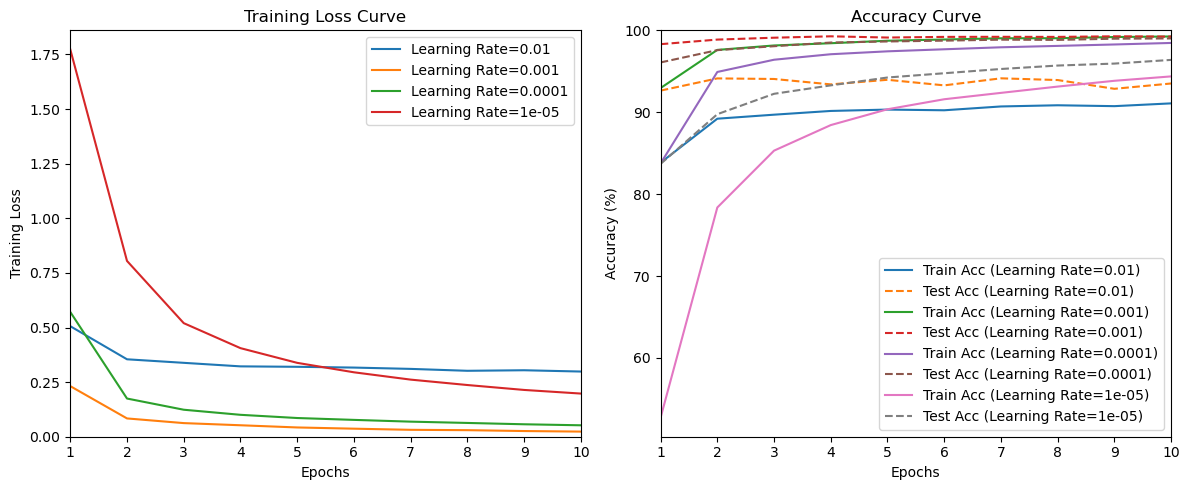

In [11]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
results = {}
epochs = 10

for lr in learning_rates:
    stats = test_parameters(learning_rate=lr, epochs=epochs)
    results[lr] = stats
  
    for epoch in range(epochs):
        if epoch == 0:
            print(f"Learning rate={lr}:")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[lr]['train_loss'][epoch]:.4f}, Train Acc: {results[lr]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[lr]['test_accuracy'][epoch]:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[lr]['train_loss'][epoch]:.4f}, Train Acc: {results[lr]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[lr]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(range(1, len(results[lr]['train_loss']) + 1), results[lr]['train_loss'], label=f'Learning Rate={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(range(1, len(results[lr]['train_accuracy']) + 1), results[lr]['train_accuracy'], label=f'Train Acc (Learning Rate={lr})')
    plt.plot(range(1, len(results[lr]['test_accuracy']) + 1), results[lr]['test_accuracy'], linestyle='--', label=f'Test Acc (Learning Rate={lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Dropout rates

Dropout rate=0.1:
Epoch 1/10, Loss: 0.1497, Train Acc: 95.40%, Test Acc: 98.38%
Epoch 2/10, Loss: 0.0471, Train Acc: 98.53%, Test Acc: 98.81%
Epoch 3/10, Loss: 0.0327, Train Acc: 98.96%, Test Acc: 98.89%
Epoch 4/10, Loss: 0.0254, Train Acc: 99.18%, Test Acc: 99.09%
Epoch 5/10, Loss: 0.0197, Train Acc: 99.34%, Test Acc: 99.09%
Epoch 6/10, Loss: 0.0155, Train Acc: 99.50%, Test Acc: 98.93%
Epoch 7/10, Loss: 0.0148, Train Acc: 99.49%, Test Acc: 99.02%
Epoch 8/10, Loss: 0.0119, Train Acc: 99.62%, Test Acc: 99.18%
Epoch 9/10, Loss: 0.0097, Train Acc: 99.69%, Test Acc: 99.04%
Epoch 10/10, Loss: 0.0084, Train Acc: 99.71%, Test Acc: 99.09%
Dropout rate=0.3:
Epoch 1/10, Loss: 0.1747, Train Acc: 94.68%, Test Acc: 98.30%
Epoch 2/10, Loss: 0.0595, Train Acc: 98.20%, Test Acc: 98.72%
Epoch 3/10, Loss: 0.0434, Train Acc: 98.66%, Test Acc: 99.11%
Epoch 4/10, Loss: 0.0345, Train Acc: 98.92%, Test Acc: 99.18%
Epoch 5/10, Loss: 0.0270, Train Acc: 99.16%, Test Acc: 99.06%
Epoch 6/10, Loss: 0.0229, Train A

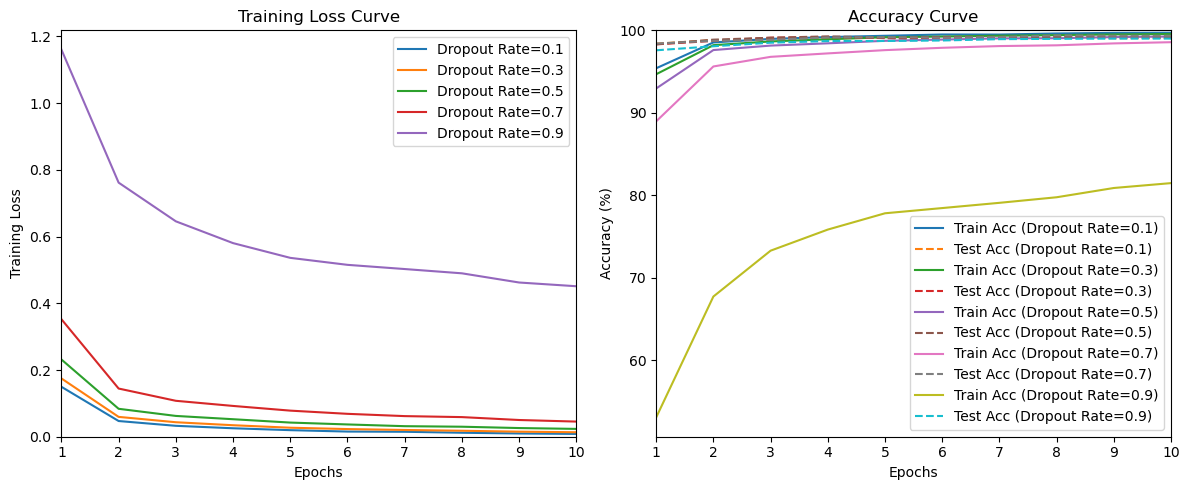

In [12]:
dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
results = {}
epochs = 10

for dr in dropout_rates:
    stats = test_parameters(dropout=dr, epochs=epochs)
    results[dr] = stats
  
    for epoch in range(epochs):
        if epoch == 0:
            print(f"Dropout rate={dr}:")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[dr]['train_loss'][epoch]:.4f}, Train Acc: {results[dr]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[dr]['test_accuracy'][epoch]:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[dr]['train_loss'][epoch]:.4f}, Train Acc: {results[dr]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[dr]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for dr in dropout_rates:
    plt.plot(range(1, len(results[dr]['train_loss']) + 1), results[dr]['train_loss'], label=f'Dropout Rate={dr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for dr in dropout_rates:
    plt.plot(range(1, len(results[dr]['train_accuracy']) + 1), results[dr]['train_accuracy'], label=f'Train Acc (Dropout Rate={dr})')
    plt.plot(range(1, len(results[dr]['test_accuracy']) + 1), results[dr]['test_accuracy'], linestyle='--', label=f'Test Acc (Dropout Rate={dr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Weight initialization

Weight Initialization=xavier_uniform:
Epoch 1/10, Loss: 0.2123, Train Acc: 93.55%, Test Acc: 98.62%
Epoch 2/10, Loss: 0.0780, Train Acc: 97.72%, Test Acc: 99.06%
Epoch 3/10, Loss: 0.0542, Train Acc: 98.40%, Test Acc: 99.00%
Epoch 4/10, Loss: 0.0456, Train Acc: 98.62%, Test Acc: 99.03%
Epoch 5/10, Loss: 0.0386, Train Acc: 98.81%, Test Acc: 99.29%
Epoch 6/10, Loss: 0.0311, Train Acc: 99.02%, Test Acc: 99.31%
Epoch 7/10, Loss: 0.0287, Train Acc: 99.15%, Test Acc: 99.34%
Epoch 8/10, Loss: 0.0250, Train Acc: 99.21%, Test Acc: 99.34%
Epoch 9/10, Loss: 0.0212, Train Acc: 99.33%, Test Acc: 99.30%
Epoch 10/10, Loss: 0.0205, Train Acc: 99.34%, Test Acc: 99.25%
Weight Initialization=uniform:
Epoch 1/10, Loss: 629678.9789, Train Acc: 12.35%, Test Acc: 32.00%
Epoch 2/10, Loss: 458.4054, Train Acc: 9.28%, Test Acc: 8.95%
Epoch 3/10, Loss: 30.9733, Train Acc: 10.12%, Test Acc: 11.89%
Epoch 4/10, Loss: 9.1611, Train Acc: 12.19%, Test Acc: 13.87%
Epoch 5/10, Loss: 4.6888, Train Acc: 13.36%, Test Acc: 1

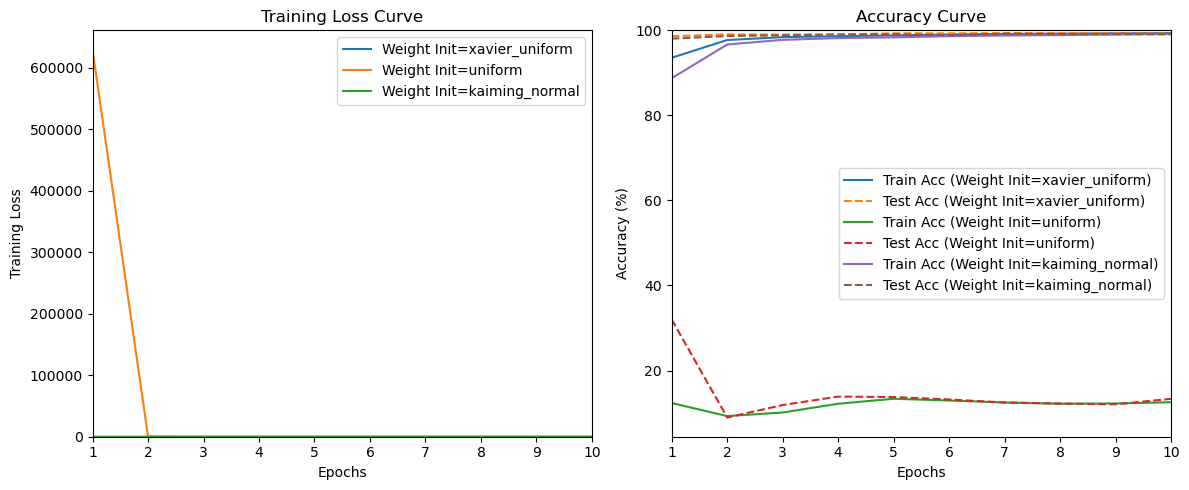

In [13]:
weight_inits = {
    'xavier_uniform': nn.init.xavier_uniform_,
    'uniform': nn.init.uniform_,
    'kaiming_normal': nn.init.kaiming_normal_
}
results = {}
epochs = 10

for init_name, init_func in weight_inits.items():
    stats = test_parameters(weight_init=init_func, epochs=epochs)
    results[init_name] = stats
  
    for epoch in range(epochs):
        if epoch == 0:
            print(f"Weight Initialization={init_name}:")
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[init_name]['train_loss'][epoch]:.4f}, Train Acc: {results[init_name]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[init_name]['test_accuracy'][epoch]:.2f}%")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[init_name]['train_loss'][epoch]:.4f}, Train Acc: {results[init_name]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[init_name]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_loss']) + 1), results[init_name]['train_loss'], label=f'Weight Init={init_name}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_accuracy']) + 1), results[init_name]['train_accuracy'], label=f'Train Acc (Weight Init={init_name})')
    plt.plot(range(1, len(results[init_name]['test_accuracy']) + 1), results[init_name]['test_accuracy'], linestyle='--', label=f'Test Acc (Weight Init={init_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Best configuration

Configuration: Learning Rate=0.001, Optimizer=Adam, Batch Size=64, Dropout=0.5, Weight Init=xavier_uniform
Epoch 1/10, Loss: 0.2123, Train Acc: 93.55%, Test Acc: 98.62%
Epoch 2/10, Loss: 0.0780, Train Acc: 97.72%, Test Acc: 99.06%
Epoch 3/10, Loss: 0.0542, Train Acc: 98.40%, Test Acc: 99.00%
Epoch 4/10, Loss: 0.0456, Train Acc: 98.62%, Test Acc: 99.03%
Epoch 5/10, Loss: 0.0386, Train Acc: 98.81%, Test Acc: 99.29%
Epoch 6/10, Loss: 0.0311, Train Acc: 99.02%, Test Acc: 99.31%
Epoch 7/10, Loss: 0.0287, Train Acc: 99.15%, Test Acc: 99.34%
Epoch 8/10, Loss: 0.0250, Train Acc: 99.21%, Test Acc: 99.34%
Epoch 9/10, Loss: 0.0212, Train Acc: 99.33%, Test Acc: 99.30%
Epoch 10/10, Loss: 0.0205, Train Acc: 99.34%, Test Acc: 99.25%


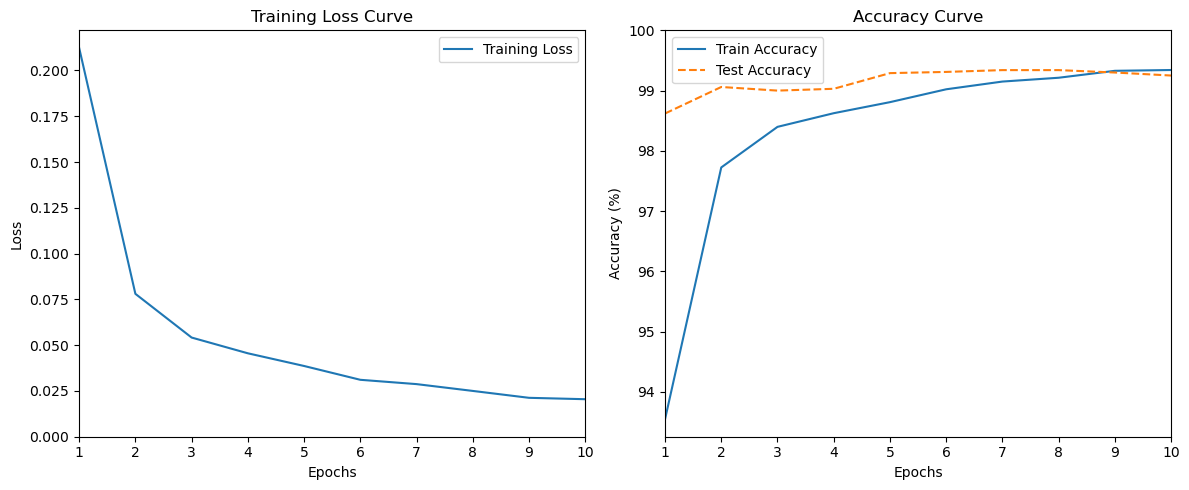

In [18]:
learning_rate = 0.001
optimizer_type = 'Adam'
batch_size = 64
dropout = 0.5
weight_init = nn.init.xavier_uniform_
epochs = 10

stats = test_parameters(learning_rate=learning_rate, optimizer_type=optimizer_type, batch_size=batch_size, dropout=dropout, weight_init=weight_init, epochs=epochs)

print(f"Configuration: Learning Rate={learning_rate}, Optimizer={optimizer_type}, Batch Size={batch_size}, Dropout={dropout}, Weight Init=xavier_uniform")
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {stats['train_loss'][epoch]:.4f}, Train Acc: {stats['train_accuracy'][epoch]:.2f}%, Test Acc: {stats['test_accuracy'][epoch]:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(stats['train_loss']) + 1), stats['train_loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(stats['train_accuracy']) + 1), stats['train_accuracy'], label='Train Accuracy')
plt.plot(range(1, len(stats['test_accuracy']) + 1), stats['test_accuracy'], linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

# Q4. Breaking the CNN

## Failed experiment 1: Uniform weight initialization

Weight Initialization=uniform:
Epoch 1/10, Loss: 629678.9789, Train Acc: 12.35%, Test Acc: 32.00%
Epoch 2/10, Loss: 458.4054, Train Acc: 9.28%, Test Acc: 8.95%
Epoch 3/10, Loss: 30.9733, Train Acc: 10.12%, Test Acc: 11.89%
Epoch 4/10, Loss: 9.1611, Train Acc: 12.19%, Test Acc: 13.87%
Epoch 5/10, Loss: 4.6888, Train Acc: 13.36%, Test Acc: 13.76%
Epoch 6/10, Loss: 3.4449, Train Acc: 12.94%, Test Acc: 13.19%
Epoch 7/10, Loss: 2.9795, Train Acc: 12.47%, Test Acc: 12.48%
Epoch 8/10, Loss: 2.6829, Train Acc: 12.18%, Test Acc: 12.24%
Epoch 9/10, Loss: 2.5710, Train Acc: 12.25%, Test Acc: 12.06%
Epoch 10/10, Loss: 2.4949, Train Acc: 12.54%, Test Acc: 13.34%


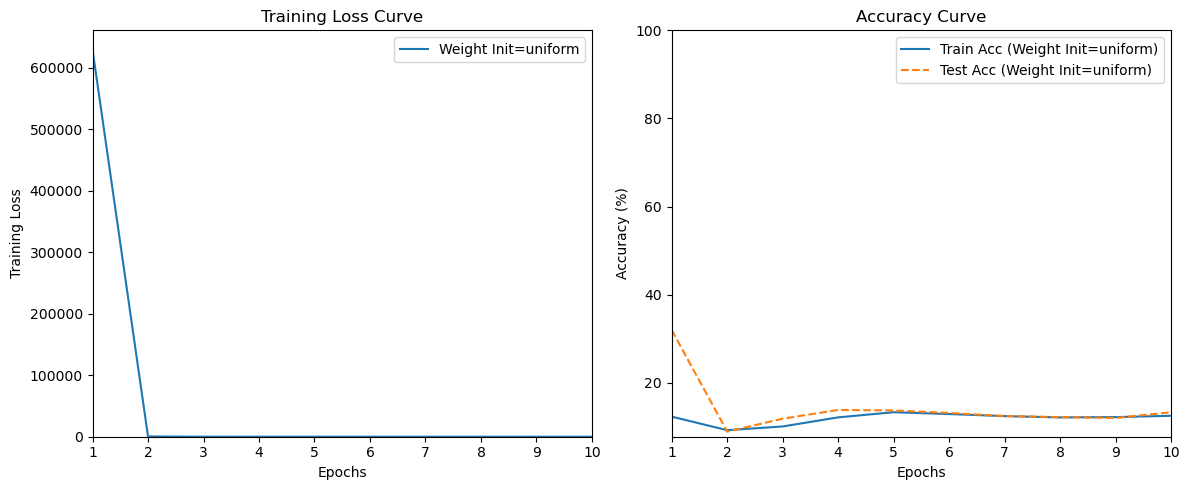

In [14]:
weight_inits = {'uniform': nn.init.uniform_}
results = {}
epochs = 10

for init_name, init_func in weight_inits.items():
    stats = test_parameters(weight_init=init_func, epochs=epochs)
    results[init_name] = stats
    print(f"Weight Initialization={init_name}:")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[init_name]['train_loss'][epoch]:.4f}, Train Acc: {results[init_name]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[init_name]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_loss']) + 1), results[init_name]['train_loss'], label=f'Weight Init={init_name}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_accuracy']) + 1), results[init_name]['train_accuracy'], label=f'Train Acc (Weight Init={init_name})')
    plt.plot(range(1, len(results[init_name]['test_accuracy']) + 1), results[init_name]['test_accuracy'], linestyle='--', label=f'Test Acc (Weight Init={init_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Failed experiment 2: High learning rate

Learning rate=0.1:
Epoch 1/10, Loss: 3.3693, Train Acc: 10.48%, Test Acc: 11.35%
Epoch 2/10, Loss: 2.3100, Train Acc: 10.51%, Test Acc: 9.58%
Epoch 3/10, Loss: 2.3099, Train Acc: 10.51%, Test Acc: 9.74%
Epoch 4/10, Loss: 2.3101, Train Acc: 10.46%, Test Acc: 9.82%
Epoch 5/10, Loss: 2.3097, Train Acc: 10.17%, Test Acc: 10.32%
Epoch 6/10, Loss: 2.3106, Train Acc: 10.29%, Test Acc: 10.28%
Epoch 7/10, Loss: 2.3096, Train Acc: 10.45%, Test Acc: 11.35%
Epoch 8/10, Loss: 2.3106, Train Acc: 10.40%, Test Acc: 10.09%
Epoch 9/10, Loss: 2.3097, Train Acc: 10.15%, Test Acc: 10.10%
Epoch 10/10, Loss: 2.3103, Train Acc: 10.17%, Test Acc: 11.35%


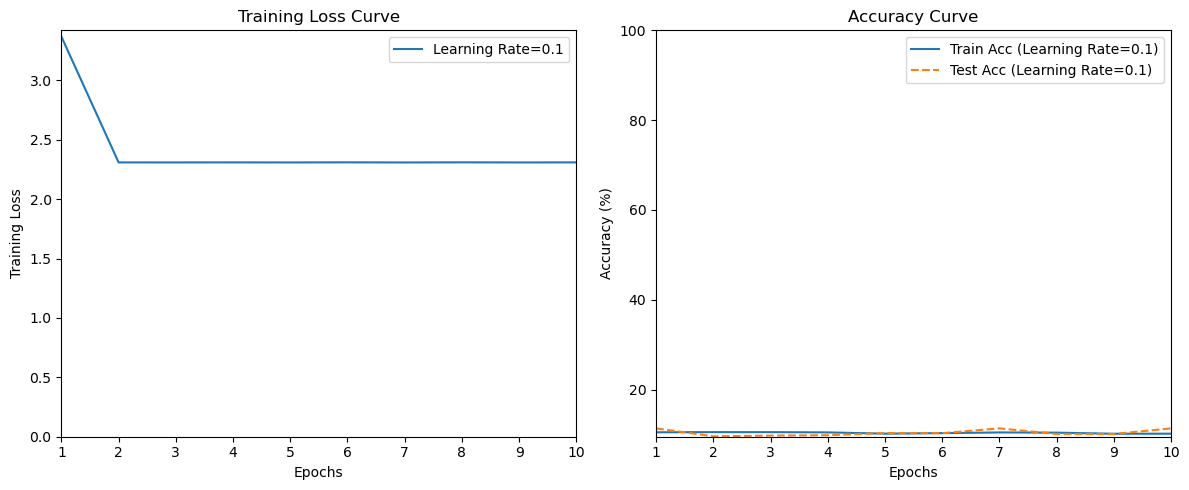

In [15]:
learning_rate = 0.1
results = {}
epochs = 10

stats = test_parameters(learning_rate=learning_rate, epochs=epochs)
results[learning_rate] = stats

print(f"Learning rate={learning_rate}:")  
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[learning_rate]['train_loss'][epoch]:.4f}, Train Acc: {results[learning_rate]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[learning_rate]['test_accuracy'][epoch]:.2f}%")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(results[learning_rate]['train_loss']) + 1), results[learning_rate]['train_loss'], label=f'Learning Rate={learning_rate}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(results[learning_rate]['train_accuracy']) + 1), results[learning_rate]['train_accuracy'], label=f'Train Acc (Learning Rate={learning_rate})')
plt.plot(range(1, len(results[learning_rate]['test_accuracy']) + 1), results[learning_rate]['test_accuracy'], linestyle='--', label=f'Test Acc (Learning Rate={learning_rate})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

## Failed experiment 3: All ones weight initialization

Weight Initialization=All ones:
Epoch 1/10, Loss: 70861.0217, Train Acc: 9.91%, Test Acc: 9.58%
Epoch 2/10, Loss: 8384.2822, Train Acc: 10.01%, Test Acc: 9.58%
Epoch 3/10, Loss: 1458.5910, Train Acc: 9.99%, Test Acc: 10.10%
Epoch 4/10, Loss: 253.0496, Train Acc: 10.15%, Test Acc: 10.14%
Epoch 5/10, Loss: 22.5014, Train Acc: 11.01%, Test Acc: 13.08%
Epoch 6/10, Loss: 2.9739, Train Acc: 12.50%, Test Acc: 13.95%
Epoch 7/10, Loss: 2.3757, Train Acc: 12.61%, Test Acc: 12.50%
Epoch 8/10, Loss: 2.3041, Train Acc: 12.40%, Test Acc: 12.55%
Epoch 9/10, Loss: 2.2925, Train Acc: 12.53%, Test Acc: 12.77%
Epoch 10/10, Loss: 2.2916, Train Acc: 12.38%, Test Acc: 12.67%


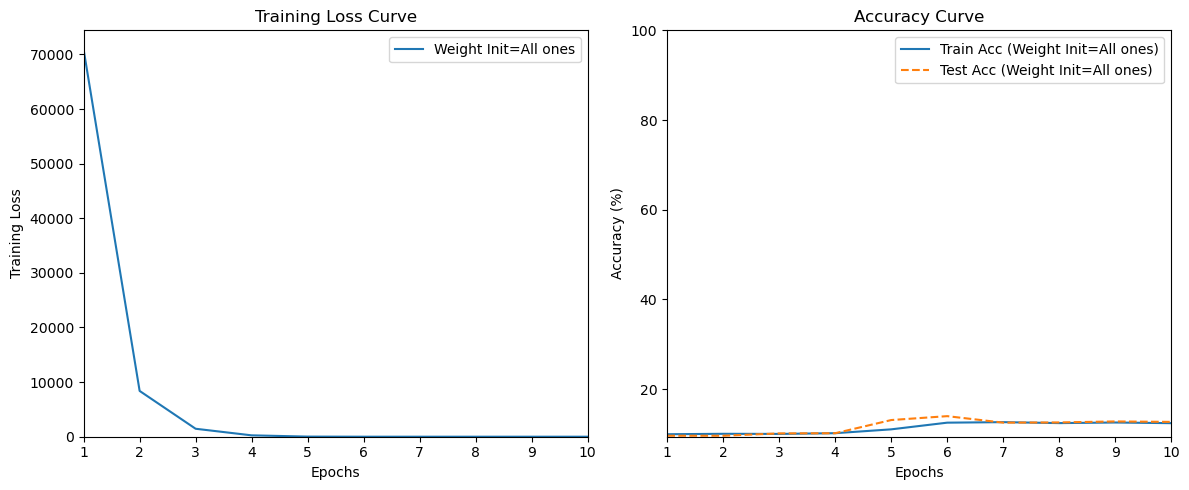

In [17]:
weight_inits = {'All ones': nn.init.ones_}
results = {}
epochs = 10

for init_name, init_func in weight_inits.items():
    stats = test_parameters(weight_init=init_func, epochs=epochs)
    results[init_name] = stats
    print(f"Weight Initialization={init_name}:")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {results[init_name]['train_loss'][epoch]:.4f}, Train Acc: {results[init_name]['train_accuracy'][epoch]:.2f}%, Test Acc: {results[init_name]['test_accuracy'][epoch]:.2f}%")
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_loss']) + 1), results[init_name]['train_loss'], label=f'Weight Init={init_name}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.xlim(1, epochs)
plt.ylim(bottom=0)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.subplot(1, 2, 2)
for init_name in weight_inits.keys():
    plt.plot(range(1, len(results[init_name]['train_accuracy']) + 1), results[init_name]['train_accuracy'], label=f'Train Acc (Weight Init={init_name})')
    plt.plot(range(1, len(results[init_name]['test_accuracy']) + 1), results[init_name]['test_accuracy'], linestyle='--', label=f'Test Acc (Weight Init={init_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.xlim(1, epochs)
plt.ylim(top=100)
plt.xticks(range(1, epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()